In [8]:
# Import Libraries
import pandas as pd
import numpy as np
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

import joblib



In [9]:
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [14]:
# Load datasets
df = pd.read_csv("/content/WELFake_Dataset.csv")
df.head(10)

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1
5,5,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1
6,6,DR BEN CARSON TARGETED BY THE IRS: “I never ha...,DR. BEN CARSON TELLS THE STORY OF WHAT HAPPENE...,1
7,7,HOUSE INTEL CHAIR On Trump-Russia Fake Story: ...,,1
8,8,Sports Bar Owner Bans NFL Games…Will Show Only...,"The owner of the Ringling Bar, located south o...",1
9,9,Latest Pipeline Leak Underscores Dangers Of Da...,"FILE – In this Sept. 15, 2005 file photo, the ...",1


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [15]:
# Keep only 'text' and 'label' columns
df = df[['text', 'label']]

# Drop missing values
df.dropna(inplace=True)

# Check balance
df['label'].value_counts()


<ipython-input-15-27cb1caf3cce>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


,count
label,
1,37067
0,35028


In [17]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)  # Remove punctuation
    text = text.lower()  # Lowercase
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])  # Lemmatize
    return text

# Apply cleaning
df['cleaned'] = df['text'].apply(clean_text)
df[['text', 'cleaned']].head(10)


,text,cleaned
0,No comment is expected from Barack Obama Membe...,comment expected barack obama member fyf911 fu...
1,Did they post their votes for Hillary already?,post vote hillary already
2,"Now, most of the demonstrators gathered last ...",demonstrator gathered last night exercising co...
3,A dozen politically active pastors came here f...,dozen politically active pastor came private d...
4,"The RS-28 Sarmat missile, dubbed Satan 2, will...",rs28 sarmat missile dubbed satan 2 replace ss1...
5,All we can say on this one is it s about time ...,say one time someone sued southern poverty law...
6,DR. BEN CARSON TELLS THE STORY OF WHAT HAPPENE...,dr ben carson tell story happened spoke obama
7,,
8,"The owner of the Ringling Bar, located south o...",owner ringling bar located south white sulphur...
9,"FILE – In this Sept. 15, 2005 file photo, the ...",file – sept 15 2005 file photo marker welcome ...


In [18]:
vocab_size = 10000
max_len = 300

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(df['cleaned'])

sequences = tokenizer.texts_to_sequences(df['cleaned'])
padded = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

labels = df['label'].values


In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    padded, labels, test_size=0.2, random_state=42
)


In [20]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64, input_length=max_len),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [21]:
history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=128,
    validation_split=0.2
)


Epoch 1/5
361/361 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.6463 - loss: 0.6232 - val_accuracy: 0.6274 - val_loss: 0.5859
Epoch 2/5
361/361 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.7750 - loss: 0.4746 - val_accuracy: 0.7070 - val_loss: 0.5506
Epoch 3/5
361/361 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.8250 - loss: 0.4264 - val_accuracy: 0.8346 - val_loss: 0.4258
Epoch 4/5
361/361 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.8290 - loss: 0.3964 - val_accuracy: 0.8760 - val_loss: 0.3763
Epoch 5/5
361/361 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.8771 - loss: 0.3160 - val_accuracy: 0.9177 - val_loss: 0.2349


In [22]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Predictions
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))


451/451 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9184 - loss: 0.2310
Test Accuracy: 0.9161
451/451 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
              precision    recall  f1-score   support

           0       0.88      0.95      0.92      7010
           1       0.95      0.88      0.92      7409

    accuracy                           0.92     14419
   macro avg       0.92      0.92      0.92     14419
weighted avg       0.92      0.92      0.92     14419



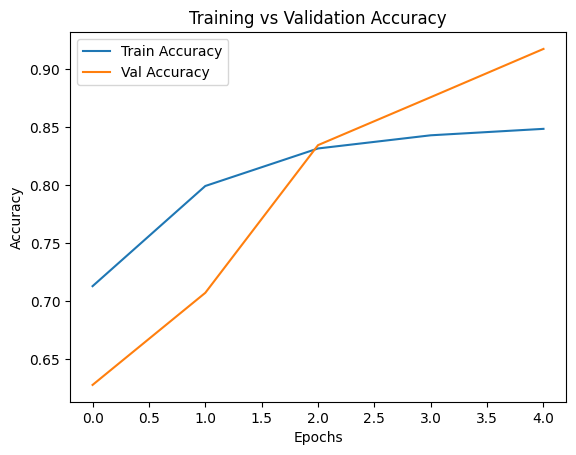

In [23]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()


In [27]:
def predict_news(text):
    clean = clean_text(text)
    seq = tokenizer.texts_to_sequences([clean])
    padded_seq = pad_sequences(seq, maxlen=max_len)
    prediction = model.predict(padded_seq)[0][0]
    return "Fake News" if prediction > 0.5 else "Real News"

# Example
predict_news("NASA and ESA are now working on a joint mission to explore Xenthara b")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


'Fake News'

In [25]:
user_input = input("Paste your news article here:\n")
result = predict_news(user_input)
print(f"Prediction: {result}")


Paste your news article here:
NASA and ESA are now working on a joint mission to explore Xenthara b using next-gen propulsion systems by 2032. This discovery reignites hopes of interstellar travel and long-term space habitation.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Prediction: Fake News
